***2. Régression Logistique Binomiale***



======================================================================

C bon
   Gap Train-CV: 0.0001C bon

 Meilleur modèle: class_weight='custom'
 Meilleur score (CV): 0.9663
 Gap Train-CV: 0.0001

 Meilleurs hyperparamètres:
C: 4.678860424711244
l1_ratio: 0.9393697376027718
max_iter: 494
penalty: l1
solver: saga
 Seuil   Recall  Precision       F1  Coût_Total
  0.25 1.000000   0.551724 0.711111          52
  0.30 1.000000   0.551724 0.711111          52
  0.20 1.000000   0.547009 0.707182          53
  0.35 0.984375   0.547826 0.703911          62
  0.40 0.968750   0.543860 0.696629          72
  0.45 0.953125   0.544643 0.693182          81
  0.55 0.937500   0.555556 0.697674          88
  0.50 0.937500   0.550459 0.693642          89
  0.60 0.906250   0.557692 0.690476         106
  0.65 0.890625   0.564356 0.690909         114

 Meilleur seuil (coût minimal): 0.25
   Coût total: 52
   Recall: 100.00%
   Precision: 55.17%
   F1-Score: 71.11%


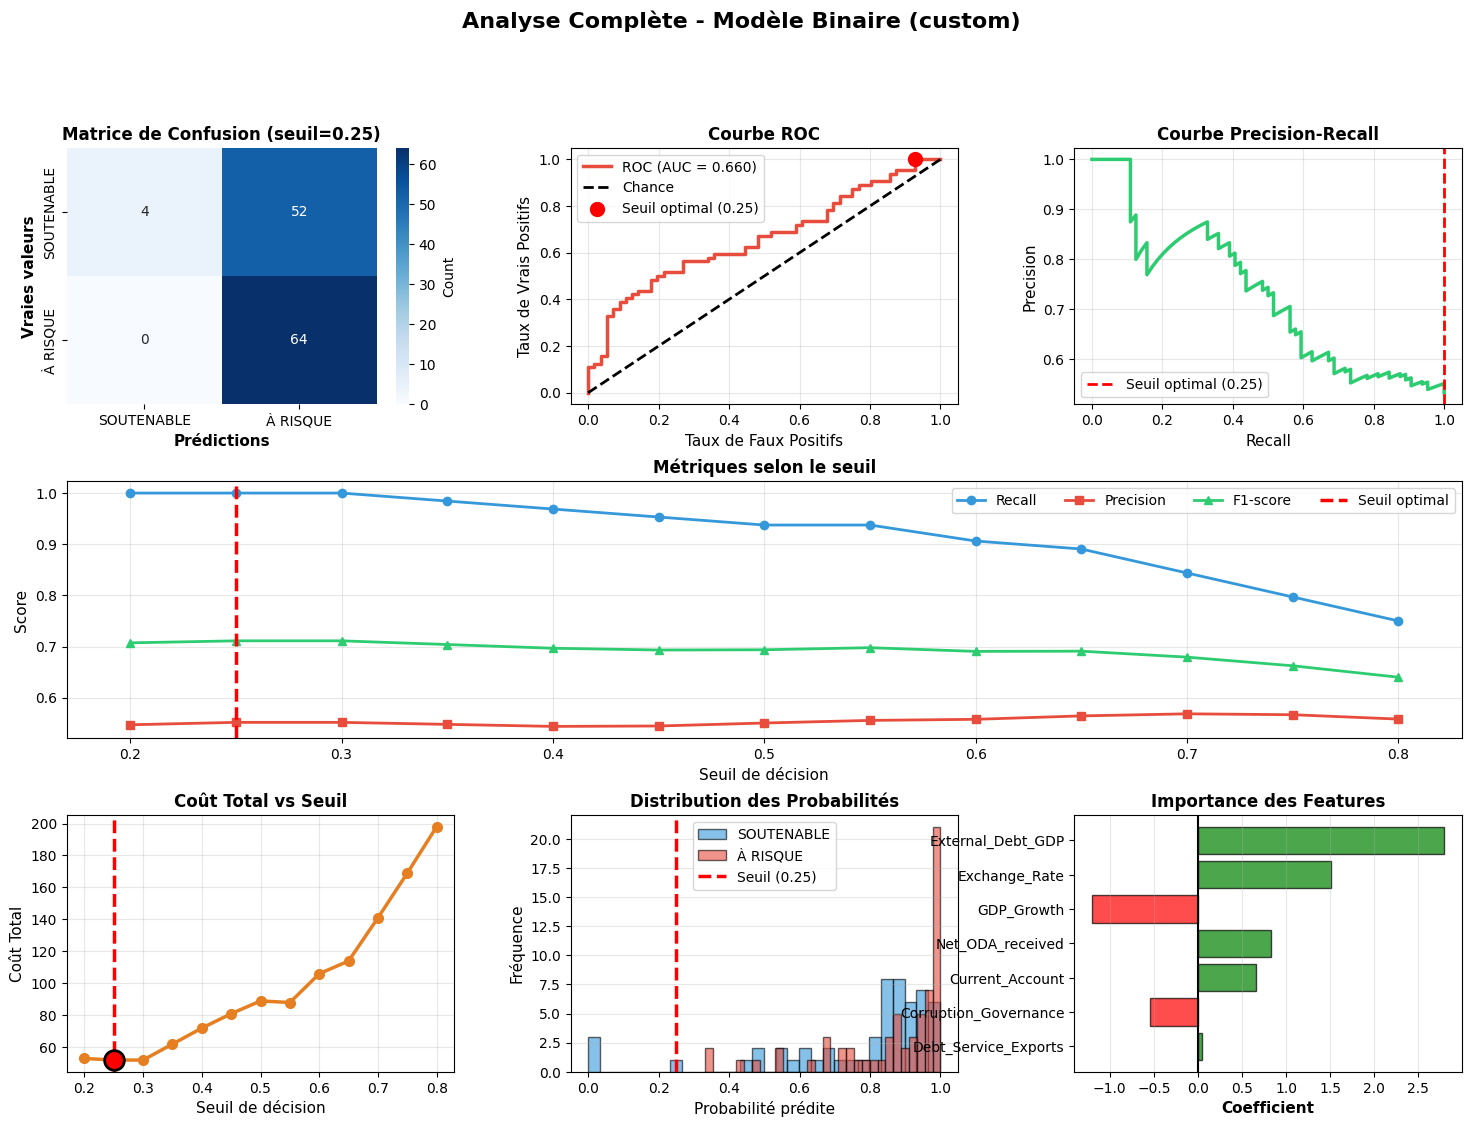


 Performance avec seuil optimal (0.25):
              precision    recall  f1-score   support

  SOUTENABLE     1.0000    0.0714    0.1333        56
    À RISQUE     0.5517    1.0000    0.7111        64

    accuracy                         0.5667       120
   macro avg     0.7759    0.5357    0.4222       120
weighted avg     0.7609    0.5667    0.4415       120

Vrais Positifs (À RISQUE bien détecté): 64
Faux Négatifs (À RISQUE raté): 0 → Coût = 0
Faux Positifs (Fausse alerte): 52 → Coût = 52
Vrais Négatifs (SOUTENABLE bien détecté): 4

 COÛT TOTAL: 52

 COMPARAISON DES STRATÉGIES:
Stratégie 'balanced':
Score CV: 0.8006
Gap: 0.0006
Stratégie 'custom weights':
Score CV: 0.9663
Gap: 0.0001

 Stratégie retenue: custom
              Feature  Coefficient
    External_Debt_GDP     2.795260
        Exchange_Rate     1.506111
           GDP_Growth    -1.202662
     Net_ODA_received     0.828531
      Current_Account     0.664777
Corruption_Governance    -0.548142
 Debt_Service_Exports     0

In [ ]:
distress_label = label_encoder.transform(['DISTRESS'])[0]
high_label = label_encoder.transform(['HIGH'])[0]

y_train_binary = ((y_train_final == distress_label) | (y_train_final == high_label)).astype(int)
y_test_binary = ((y_test_final == distress_label) | (y_test_final == high_label)).astype(int)

ratio = (~y_train_binary.astype(bool)).sum() / y_train_binary.sum()

cost_fn = 10
cost_fp = 1

n_at_risque = y_train_binary.sum()
n_soutenable = (~y_train_binary.astype(bool)).sum()
n_total = len(y_train_binary)

weight_at_risque = (cost_fn / (cost_fn + cost_fp)) * (n_total / n_at_risque)
weight_soutenable = (cost_fp / (cost_fn + cost_fp)) * (n_total / n_soutenable)

total_weight = weight_at_risque + weight_soutenable
weight_at_risque = weight_at_risque / (total_weight / 2)
weight_soutenable = weight_soutenable / (total_weight / 2)

class_weight_custom = {1: weight_at_risque, 0: weight_soutenable}

def cost_sensitive_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        return 0
    total_cost = fn * cost_fn + fp * cost_fp
    max_cost = len(y_true) * max(cost_fn, cost_fp)
    return 1 - (total_cost / max_cost)

cost_scorer = make_scorer(cost_sensitive_score)


search_spaces_binary = {
    'C': Real(0.001, 100, prior='log-uniform'),
    'penalty': Categorical(['l1', 'l2', 'elasticnet']),
    'l1_ratio': Real(0.0, 1.0),
    'solver': Categorical(['saga']),
    'max_iter': Integer(200, 2000),
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


model_balanced = LogisticRegression(
    random_state=42,
    warm_start=True,
    class_weight='balanced'
)

bayes_search_balanced = BayesSearchCV(
    estimator=model_balanced,
    search_spaces=search_spaces_binary,
    n_iter=30,
    cv=cv_strategy,
    scoring=cost_scorer,
    n_jobs=-1,
    random_state=42,
    verbose=0,
    return_train_score=True
)

bayes_search_balanced.fit(X_train_final, y_train_binary)

cv_results_balanced = pd.DataFrame(bayes_search_balanced.cv_results_)
best_idx_balanced = bayes_search_balanced.best_index_
train_score_balanced = cv_results_balanced.loc[best_idx_balanced, 'mean_train_score']
test_score_balanced = cv_results_balanced.loc[best_idx_balanced, 'mean_test_score']
gap_balanced = train_score_balanced - test_score_balanced

if gap_balanced < 0.05:
    print("C bon")
elif gap_balanced < 0.10:
    print("Rsique d'overfitting")
else:
    print("Overfitting")


model_custom = LogisticRegression(
    random_state=42,
    warm_start=True,
    class_weight=class_weight_custom
)

bayes_search_custom = BayesSearchCV(
    estimator=model_custom,
    search_spaces=search_spaces_binary,
    n_iter=30,
    cv=cv_strategy,
    scoring=cost_scorer,
    n_jobs=-1,
    random_state=42,
    verbose=0,
    return_train_score=True
)

bayes_search_custom.fit(X_train_final, y_train_binary)

cv_results_custom = pd.DataFrame(bayes_search_custom.cv_results_)
best_idx_custom = bayes_search_custom.best_index_
train_score_custom = cv_results_custom.loc[best_idx_custom, 'mean_train_score']
test_score_custom = cv_results_custom.loc[best_idx_custom, 'mean_test_score']
gap_custom = train_score_custom - test_score_custom

print(f"   Gap Train-CV: {gap_custom:.4f}", end="")
if gap_custom < 0.05:
    print("C bon")
elif gap_custom < 0.10:
    print("Overfitting")
else:
    print("Overfitting")


models_comparison = {
    'balanced': {
        'model': bayes_search_balanced,
        'score': bayes_search_balanced.best_score_,
        'gap': gap_balanced
    },
    'custom': {
        'model': bayes_search_custom,
        'score': bayes_search_custom.best_score_,
        'gap': gap_custom
    }
}

best_choice = None
best_score_val = -np.inf

for name, info in models_comparison.items():
    adjusted_score = info['score'] - (info['gap'] * 2)
    if adjusted_score > best_score_val:
        best_score_val = adjusted_score
        best_choice = name

weight_type = best_choice
bayes_search_binary = models_comparison[best_choice]['model']

print(f"\n Meilleur modèle: class_weight='{weight_type}'")
print(f" Meilleur score (CV): {bayes_search_binary.best_score_:.4f}")
print(f" Gap Train-CV: {models_comparison[best_choice]['gap']:.4f}")
print(f"\n Meilleurs hyperparamètres:")
for param, value in bayes_search_binary.best_params_.items():
    print(f"{param}: {value}")

best_model_binary = bayes_search_binary.best_estimator_



y_pred_proba_binary = best_model_binary.predict_proba(X_test_final)[:, 1]

thresholds_to_test = np.arange(0.20, 0.80, 0.05)
results = []

for threshold in thresholds_to_test:
    y_pred_threshold = (y_pred_proba_binary >= threshold).astype(int)

    cm = confusion_matrix(y_test_binary, y_pred_threshold)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        continue

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    total_cost = fn * cost_fn + fp * cost_fp

    results.append({
        'Seuil': threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn,
        'Coût_Total': total_cost
    })

results_df = pd.DataFrame(results)

top_results = results_df.nsmallest(10, 'Coût_Total')
print(top_results[['Seuil', 'Recall', 'Precision', 'F1', 'Coût_Total']].to_string(index=False))

best_threshold_idx = results_df['Coût_Total'].idxmin()
best_threshold = results_df.loc[best_threshold_idx, 'Seuil']

print(f"\n Meilleur seuil (coût minimal): {best_threshold:.2f}")
print(f"   Coût total: {results_df.loc[best_threshold_idx, 'Coût_Total']:.0f}")
print(f"   Recall: {results_df.loc[best_threshold_idx, 'Recall']:.2%}")
print(f"   Precision: {results_df.loc[best_threshold_idx, 'Precision']:.2%}")
print(f"   F1-Score: {results_df.loc[best_threshold_idx, 'F1']:.2%}")

y_pred_binary_final = (y_pred_proba_binary >= best_threshold).astype(int)



fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
cm = confusion_matrix(y_test_binary, y_pred_binary_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['SOUTENABLE', 'À RISQUE'],
            yticklabels=['SOUTENABLE', 'À RISQUE'],
            ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_xlabel('Prédictions', fontsize=11, fontweight='bold')
ax1.set_ylabel('Vraies valeurs', fontsize=11, fontweight='bold')
ax1.set_title(f'Matrice de Confusion (seuil={best_threshold:.2f})',
              fontsize=12, fontweight='bold')

ax2 = fig.add_subplot(gs[0, 1])
fpr, tpr, thresholds_roc = roc_curve(y_test_binary, y_pred_proba_binary)
roc_auc = roc_auc_score(y_test_binary, y_pred_proba_binary)

ax2.plot(fpr, tpr, color='#e74c3c', lw=2.5, label=f'ROC (AUC = {roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')

idx_threshold = np.argmin(np.abs(thresholds_roc - best_threshold))
ax2.scatter([fpr[idx_threshold]], [tpr[idx_threshold]],
           color='red', s=100, zorder=5, label=f'Seuil optimal ({best_threshold:.2f})')
ax2.set_xlabel('Taux de Faux Positifs', fontsize=11)
ax2.set_ylabel('Taux de Vrais Positifs', fontsize=11)
ax2.set_title('Courbe ROC', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(gs[0, 2])
precision_curve, recall_curve, _ = precision_recall_curve(y_test_binary, y_pred_proba_binary)

ax3.plot(recall_curve, precision_curve, color='#2ecc71', lw=2.5)
ax3.axvline(x=results_df.loc[best_threshold_idx, 'Recall'],
           color='red', linestyle='--', lw=2, label=f'Seuil optimal ({best_threshold:.2f})')
ax3.set_xlabel('Recall', fontsize=11)
ax3.set_ylabel('Precision', fontsize=11)
ax3.set_title('Courbe Precision-Recall', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4 = fig.add_subplot(gs[1, :])
ax4.plot(results_df['Seuil'], results_df['Recall'], 'o-',
         label='Recall', lw=2, markersize=6, color='#3498db')
ax4.plot(results_df['Seuil'], results_df['Precision'], 's-',
         label='Precision', lw=2, markersize=6, color='#e74c3c')
ax4.plot(results_df['Seuil'], results_df['F1'], '^-',
         label='F1-score', lw=2, markersize=6, color='#2ecc71')
ax4.axvline(x=best_threshold, color='red', linestyle='--',
           label=f'Seuil optimal', lw=2.5)
ax4.set_xlabel('Seuil de décision', fontsize=11)
ax4.set_ylabel('Score', fontsize=11)
ax4.set_title('Métriques selon le seuil', fontsize=12, fontweight='bold')
ax4.legend(loc='best', ncol=4)
ax4.grid(True, alpha=0.3)

ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(results_df['Seuil'], results_df['Coût_Total'], 'o-',
         lw=2.5, markersize=7, color='#e67e22')
ax5.axvline(x=best_threshold, color='red', linestyle='--', lw=2.5)
ax5.scatter([best_threshold], [results_df.loc[best_threshold_idx, 'Coût_Total']],
           color='red', s=200, zorder=5, edgecolors='black', linewidths=2)
ax5.set_xlabel('Seuil de décision', fontsize=11)
ax5.set_ylabel('Coût Total', fontsize=11)
ax5.set_title('Coût Total vs Seuil', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(gs[2, 1])
ax6.hist(y_pred_proba_binary[y_test_binary == 0], bins=30, alpha=0.6,
         label='SOUTENABLE', color='#3498db', edgecolor='black')
ax6.hist(y_pred_proba_binary[y_test_binary == 1], bins=30, alpha=0.6,
         label='À RISQUE', color='#e74c3c', edgecolor='black')
ax6.axvline(x=best_threshold, color='red', linestyle='--', lw=2.5,
           label=f'Seuil ({best_threshold:.2f})')
ax6.set_xlabel('Probabilité prédite', fontsize=11)
ax6.set_ylabel('Fréquence', fontsize=11)
ax6.set_title('Distribution des Probabilités', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

ax7 = fig.add_subplot(gs[2, 2])
coef_binary = best_model_binary.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Coefficient': coef_binary,
    'Abs_Coefficient': np.abs(coef_binary)
}).sort_values('Abs_Coefficient', ascending=True)

colors_bar = ['red' if x < 0 else 'green' for x in feature_importance['Coefficient']]
ax7.barh(feature_importance['Feature'], feature_importance['Coefficient'],
        color=colors_bar, alpha=0.7, edgecolor='black')
ax7.set_xlabel('Coefficient', fontsize=11, fontweight='bold')
ax7.set_title('Importance des Features', fontsize=12, fontweight='bold')
ax7.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
ax7.grid(axis='x', alpha=0.3)

plt.suptitle(f'Analyse Complète - Modèle Binaire ({weight_type})',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


print(f"\n Performance avec seuil optimal ({best_threshold:.2f}):")
print(classification_report(y_test_binary, y_pred_binary_final,
                           target_names=['SOUTENABLE', 'À RISQUE'], digits=4))


tn, fp, fn, tp = confusion_matrix(y_test_binary, y_pred_binary_final).ravel()
print(f"Vrais Positifs (À RISQUE bien détecté): {tp}")
print(f"Faux Négatifs (À RISQUE raté): {fn} → Coût = {fn * cost_fn}")
print(f"Faux Positifs (Fausse alerte): {fp} → Coût = {fp * cost_fp}")
print(f"Vrais Négatifs (SOUTENABLE bien détecté): {tn}")
print(f"\n COÛT TOTAL: {fn * cost_fn + fp * cost_fp}")

print(f"\n COMPARAISON DES STRATÉGIES:")
print(f"Stratégie 'balanced':")
print(f"Score CV: {bayes_search_balanced.best_score_:.4f}")
print(f"Gap: {gap_balanced:.4f}")
print(f"Stratégie 'custom weights':")
print(f"Score CV: {bayes_search_custom.best_score_:.4f}")
print(f"Gap: {gap_custom:.4f}")
print(f"\n Stratégie retenue: {weight_type}")

feature_importance_sorted = feature_importance.sort_values('Abs_Coefficient', ascending=False)
print(feature_importance_sorted[['Feature', 'Coefficient']].to_string(index=False))